#Time Series Forecasting with Yahoo Stock Price

Carlos Medina Flores A01753742

## INTRODUCCIÓN

Este proyecto busca predecir el comportamiento de precios de acciones utilizando datos históricos proporcionados por Yahoo Finance, que incluyen precios diarios de apertura, cierre, máximos, mínimos, volumen de transacciones y precios ajustados al cierre. Para capturar patrones temporales en estos datos, se ha diseñado una red neuronal con capas LSTM (Long Short-Term Memory), que son particularmente útiles para procesar secuencias de tiempo. La predicción de precios en el mercado de valores es importante para anticipar tendencias y apoyar la toma de decisiones financieras, aunque implica el reto de modelar una serie temporal que tiende a ser volátil y no lineal. Este análisis tiene como objetivo explorar y optimizar el rendimiento de la red LSTM para brindar una predicción confiable de los precios futuros.

In [1]:
!pip install --upgrade jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional

In [3]:
df = pd.read_csv('yahoo_stock.csv')

In [4]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [6]:
df[1:].describe()

,High,Low,Open,Close,Volume,Adj Close
count,1824.000000,1824.000000,1824.000000,1824.000000,1.824000e+03,1824.000000
mean,2661.028491,2633.119898,2648.010833,2648.163996,3.869781e+09,2648.163996
std,409.579291,404.214561,407.071584,407.200628,1.087871e+09,407.200628
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.942444,2327.274963,2341.979980,2335.422546,3.257950e+09,2335.422546
50%,2696.250000,2669.295044,2685.704956,2683.340088,3.610050e+09,2683.340088
75%,2930.820007,2900.917480,2914.260071,2917.577515,4.142850e+09,2917.577515
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

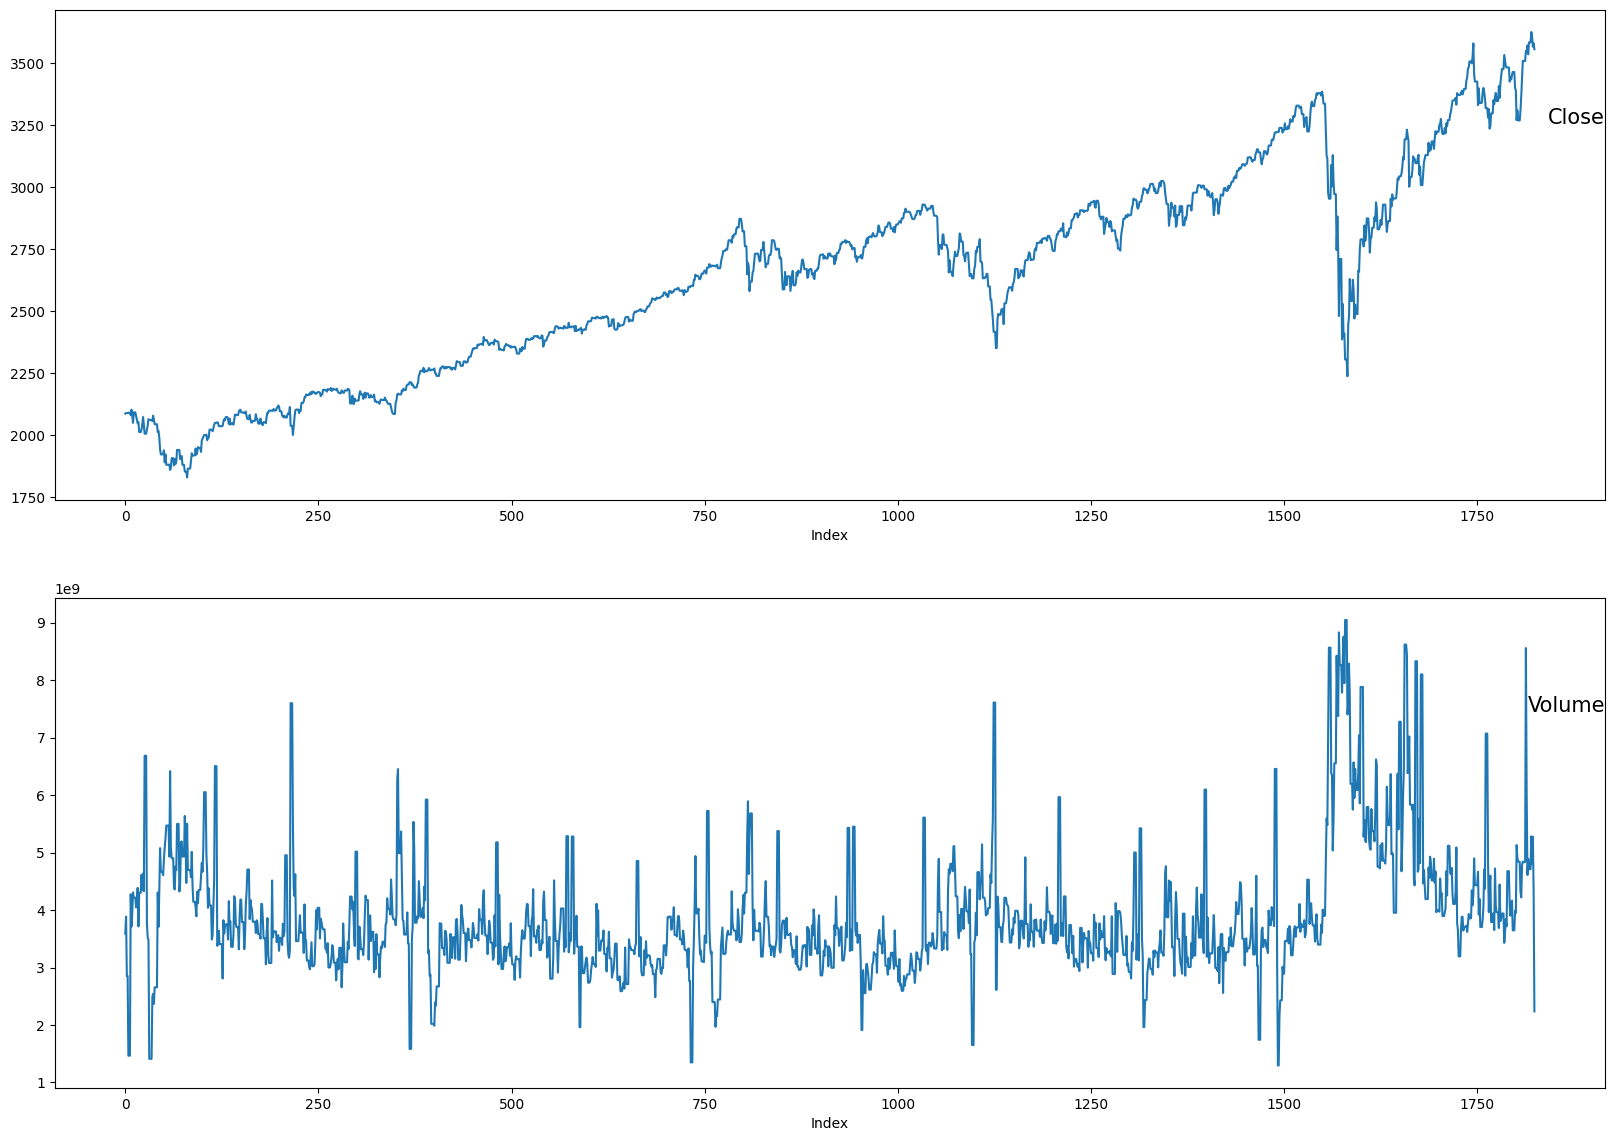

In [8]:
values = df.values

# Se seleccionan las columnas a graficar
columnas = [4, 5]
i = 1

# Se grafican las columnas seleccionadas
plt.figure(figsize=(20,14))
for col in columnas:
    plt.subplot(len(columnas), 1, i)
    plt.plot(values[:, col])
    plt.xlabel('Index')
    plt.title(df.columns[col], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

## Modelo

In [9]:
# Convertir la columna de fecha a timestamp si es necesario
df['Date'] = pd.to_datetime(df['Date'])

# Dividir en entrenamiento y prueba (80% - 20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

### Modelos Univariables
El modelo univariable se construye utilizando únicamente el precio de cierre de las acciones como variable de entrada para predecir su valor futuro. Aunque este enfoque es más sencillo y rápido de entrenar, tiene limitaciones, especialmente en mercados volátiles como el de las acciones, donde otros factores (como volumen o precios de apertura) pueden influir significativamente.

El propósito de este modelo es evaluar si el precio de cierre por sí solo puede capturar las tendencias y patrones necesarios para hacer predicciones. Sin embargo, es probable que este enfoque no sea tan preciso como un modelo multivariable que considere más factores.

In [10]:
"""# Definir la longitud de secuencia
seq_length = 15  # Aquí podrías probar diferentes periodos de dias para predecir las acciones

# Seleccionar la variable objetivo
train_target = train['Close'].iloc[seq_length:].values
test_target = test['Close'].iloc[seq_length:].values

# Crear el dataset de secuencias para entrenamiento y prueba
training = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=train['Close'].values,
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32
)

validation = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=test['Close'].values,
    targets=test_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32
)

# Definir el modelo secuencial univariable
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_length, 1)),  # Capa Input explícita
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model_1.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

# Early stopping para evitar sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min',
    restore_best_weights=True
)

# Entrenar el modelo
history = model_1.fit(
    training,
    epochs=100,
    validation_data=validation,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de entrenamiento
train_loss, train_mae = model_1.evaluate(training)
print(f"Train MAE: {train_mae:.2f}")
"""

'# Definir la longitud de secuencia\nseq_length = 15  # Aquí podrías probar diferentes periodos de dias para predecir las acciones\n\n# Seleccionar la variable objetivo\ntrain_target = train[\'Close\'].iloc[seq_length:].values\ntest_target = test[\'Close\'].iloc[seq_length:].values\n\n# Crear el dataset de secuencias para entrenamiento y prueba\ntraining = tf.keras.preprocessing.timeseries_dataset_from_array(\n    data=train[\'Close\'].values,\n    targets=train_target,\n    sequence_length=seq_length,\n    sequence_stride=1,\n    batch_size=32\n)\n\nvalidation = tf.keras.preprocessing.timeseries_dataset_from_array(\n    data=test[\'Close\'].values,\n    targets=test_target,\n    sequence_length=seq_length,\n    sequence_stride=1,\n    batch_size=32\n)\n\n# Definir el modelo secuencial univariable\nmodel_1 = tf.keras.models.Sequential([\n    tf.keras.layers.Input(shape=(seq_length, 1)),  # Capa Input explícita\n    tf.keras.layers.LSTM(64),\n    tf.keras.layers.Dense(1)\n])\n\n# Compil

In [11]:
"""# Definir la longitud de secuencia
seq_length = 180  # Aquí podrías probar diferentes periodos de dias para predecir las acciones

# Seleccionar la variable objetivo
train_target = train['Close'].iloc[seq_length:].values
test_target = test['Close'].iloc[seq_length:].values

# Crear el dataset de secuencias para entrenamiento y prueba
training = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=train['Close'].values,
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32
)

validation = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=test['Close'].values,
    targets=test_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32
)

### CORRECION DE LOS COMENTARIOS
# Definir el modelo secuencial univariable
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_length, 1)),  # Capa Input explícita
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model_2.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

# Early stopping para evitar sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min',
    restore_best_weights=True
)

# Entrenar el modelo
history = model_2.fit(
    training,
    epochs=100,
    validation_data=validation,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de entrenamiento
train_loss, train_mae = model_2.evaluate(training)
print(f"Train MAE: {train_mae:.2f}")
"""

'# Definir la longitud de secuencia\nseq_length = 180  # Aquí podrías probar diferentes periodos de dias para predecir las acciones\n\n# Seleccionar la variable objetivo\ntrain_target = train[\'Close\'].iloc[seq_length:].values\ntest_target = test[\'Close\'].iloc[seq_length:].values\n\n# Crear el dataset de secuencias para entrenamiento y prueba\ntraining = tf.keras.preprocessing.timeseries_dataset_from_array(\n    data=train[\'Close\'].values,\n    targets=train_target,\n    sequence_length=seq_length,\n    sequence_stride=1,\n    batch_size=32\n)\n\nvalidation = tf.keras.preprocessing.timeseries_dataset_from_array(\n    data=test[\'Close\'].values,\n    targets=test_target,\n    sequence_length=seq_length,\n    sequence_stride=1,\n    batch_size=32\n)\n\n### CORRECION DE LOS COMENTARIOS\n# Definir el modelo secuencial univariable\nmodel_2 = tf.keras.models.Sequential([\n    tf.keras.layers.Input(shape=(seq_length, 1)),  # Capa Input explícita\n    tf.keras.layers.LSTM(256),\n    tf.k

### Modelos Multivariables

El modelo multivariable considera múltiples características del mercado, como el precio de apertura, precio alto, precio bajo, volumen de transacciones, y precio ajustado al cierre, para predecir el precio de cierre. Al incorporar varias variables, el modelo tiene acceso a más información, lo que le permite capturar mejor las relaciones complejas entre estos factores y mejorar la precisión de las predicciones, especialmente en mercados volátiles como el de las acciones.

Este enfoque busca identificar cómo las diferentes variables interactúan entre sí y cómo influyen en el comportamiento del precio de cierre. Al considerar más datos, el modelo puede aprender patrones más robustos y ser más efectivo en la predicción, comparado con un modelo univariable. Sin embargo, también puede ser más costoso en términos de entrenamiento y requiere una mayor cantidad de datos para generalizar correctamente.

**Modelo 1:**

seq_length: 15 Probando un plazo corto de 2 semanas para ver como funciona el modelo

Arquitectura: 3 capas LSTM seguidas de un dropout para ayudar a que el modelo sea mas robusto y no dependa de pocas neuronas

Épocas: 100 epocas aunque tiene earlystopping

Resultado final (Validation MSE): 625.79

In [12]:
seq_length = 15
# Variables seleccionadas para el modelo multivariable
variables = ['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']  # Selecciona las variables relevantes

# Definir la variable objetivo (usamos 'Close' como ejemplo)
train_target = train['Close'].iloc[seq_length:].values
test_target = test['Close'].iloc[seq_length:].values

# Crear el dataset de secuencias multivariable para entrenamiento y validación
training = tf.keras.utils.timeseries_dataset_from_array(
    data=train[variables].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle=False
)

validation = tf.keras.utils.timeseries_dataset_from_array(
    data=test[variables].to_numpy().astype(np.float32),
    targets=test_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle=False
)

###CORRECION DE LOS COMENTARIOS
# Definir el modelo multivariable
multivar_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_length, len(variables))),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),  # Una capa más
    tf.keras.layers.Dropout(0.2),  # Regularización Dropout
    tf.keras.layers.Dense(64, activation='relu'),  # Aumentar las neuronas
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
multivar_model_1.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

# Early stopping para evitar sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min',
    restore_best_weights=True
)

# Entrenar el modelo
history = multivar_model_1.fit(
    training,
    epochs=100,
    validation_data=validation,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
valid_loss, valid_mae = multivar_model_1.evaluate(validation)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 5173557.0000 - mean_absolute_error: 2257.1523 - val_loss: 9931137.0000 - val_mean_absolute_error: 3139.0728
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5043560.0000 - mean_absolute_error: 2228.6877 - val_loss: 9668957.0000 - val_mean_absolute_error: 3097.0310
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4839429.5000 - mean_absolute_error: 2182.8098 - val_loss: 9309286.0000 - val_mean_absolute_error: 3038.4089
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4566682.5000 - mean_absolute_error: 2119.8516 - val_loss: 8852882.0000 - val_mean_absolute_error: 2962.3516
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4229551.5000 - mean_absolute_error: 2039.2622 - val_loss: 8309466.5000 - val_mean_absolute_error: 2869.1658
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3842033.5000 - mean_absolute_error: 1942.4121 - val_loss: 7695108.5000 - val_mean_absolute_error: 27

**Modelo 2:**

seq_length: 120 Probando un plazo mas largo de 4 meses para ver si ayuda al modelo a encontrar alguna tendencia

Arquitectura: Fundamnetalmente lo mismo que el modelo 1

Épocas: 100 epocas aunque tiene earlystopping

Resultado final (Validation MSE): 606.35

In [13]:
seq_length = 120
# Variables seleccionadas para el modelo multivariable
variables = ['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']  # Selecciona las variables relevantes

# Definir la variable objetivo (usamos 'Close' como ejemplo)
train_target = train['Close'].iloc[seq_length:].values
test_target = test['Close'].iloc[seq_length:].values

# Crear el dataset de secuencias multivariable para entrenamiento y validación
training = tf.keras.utils.timeseries_dataset_from_array(
    data=train[variables].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle= False
)

validation = tf.keras.utils.timeseries_dataset_from_array(
    data=test[variables].to_numpy().astype(np.float32),
    targets=test_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle=False
)

###CORRECION DE LOS COMENTARIOS
# Definir el modelo multivariable
multivar_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_length, len(variables))),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),  # Una capa más
    tf.keras.layers.Dropout(0.2),  # Regularización Dropout
    tf.keras.layers.Dense(64, activation='relu'),  # Aumentar las neuronas
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
multivar_model_2.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

# Early stopping para evitar sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min',
    restore_best_weights=True
)

# Entrenar el modelo
history = multivar_model_2.fit(
    training,
    epochs=100,
    validation_data=validation,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
valid_loss, valid_mae = multivar_model_2.evaluate(validation)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 5451888.0000 - mean_absolute_error: 2321.1592 - val_loss: 9946753.0000 - val_mean_absolute_error: 3140.1860
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5337218.0000 - mean_absolute_error: 2296.4883 - val_loss: 9741496.0000 - val_mean_absolute_error: 3107.3318
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5167749.0000 - mean_absolute_error: 2259.6643 - val_loss: 9435079.0000 - val_mean_absolute_error: 3057.6289
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4923974.5000 - mean_absolute_error: 2205.5493 - val_loss: 9015405.0000 - val_mean_absolute_error: 2988.2134
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4600491.0000 - mean_absolute_error: 2131.3315 - val_loss: 8497744.0000 - val_mean_absolute_error: 2900.3032
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4217385.5000 - mean_absolute_error: 2039.9336 - val_loss: 7899802.5000 - val_mean_absolute_error: 27

**Modelo 3:**

seq_length: 60 Un valor intermedio de 2 meses para que el modelo tenga memoria de los antecedentes pero que no se sesgue tanto por alguna anomalia de tiempo atras

Arquitectura: En cuanto a capas es lo mismo que los otros modelos pero cada capa cuenta con mas neuronas para intentar darle al modelo mayor oportunidad de captar patrones temporales

Épocas: 100 epocas aunque tiene earlystopping

Resultado final (Validation MSE): 607.24

In [19]:
seq_length = 60
# Variables seleccionadas para el modelo multivariable
variables = ['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']  # Selecciona las variables relevantes

# Definir la variable objetivo (usamos 'Close' como ejemplo)
train_target = train['Close'].iloc[seq_length:].values
test_target = test['Close'].iloc[seq_length:].values

# Crear el dataset de secuencias multivariable para entrenamiento y validación
training = tf.keras.utils.timeseries_dataset_from_array(
    data=train[variables].to_numpy().astype(np.float32),
    targets=train_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle= False
)

validation = tf.keras.utils.timeseries_dataset_from_array(
    data=test[variables].to_numpy().astype(np.float32),
    targets=test_target,
    sequence_length=seq_length,
    sequence_stride=1,
    batch_size=32,
    shuffle=False
)

###CORRECION DE LOS COMENTARIOS
# Definir el modelo multivariable
multivar_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_length, len(variables))),  # Capa Input explícita
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),  # Una capa más
    tf.keras.layers.Dropout(0.2),  # Regularización Dropout
    tf.keras.layers.Dense(128, activation='relu'),  # Aumentar las neuronas
    tf.keras.layers.Dense(128, activation='relu'),  # Aumentar las neuronas
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
multivar_model_3.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

# Early stopping para evitar sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min',
    restore_best_weights=True
)

# Entrenar el modelo
history = multivar_model_3.fit(
    training,
    epochs=100,
    validation_data=validation,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
valid_loss, valid_mae = multivar_model_3.evaluate(validation)
print(f"Validation MAE: {valid_mae:.2f}")

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 5178944.5000 - mean_absolute_error: 2260.8628 - val_loss: 8732401.0000 - val_mean_absolute_error: 2940.2102
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3338779.7500 - mean_absolute_error: 1823.2266 - val_loss: 1919236.8750 - val_mean_absolute_error: 1353.3933
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 22556.9004 - mean_absolute_error: 117.5629 - val_loss: 172540.2188 - val_mean_absolute_error: 363.6060
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 364882.0625 - mean_absolute_error: 524.3966 - val_loss: 238895.5312 - val_mean_absolute_error: 435.1147
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 316827.0938 - mean_absolute_error: 492.0929 - val_loss: 231942.6875 - val_mean_absolute_error: 427.9705
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 318597.0938 - mean_absolute_error: 491.7287 - val_loss: 233080.9688 - val_mean_absolute_error: 429.1517
Epoch 7/1

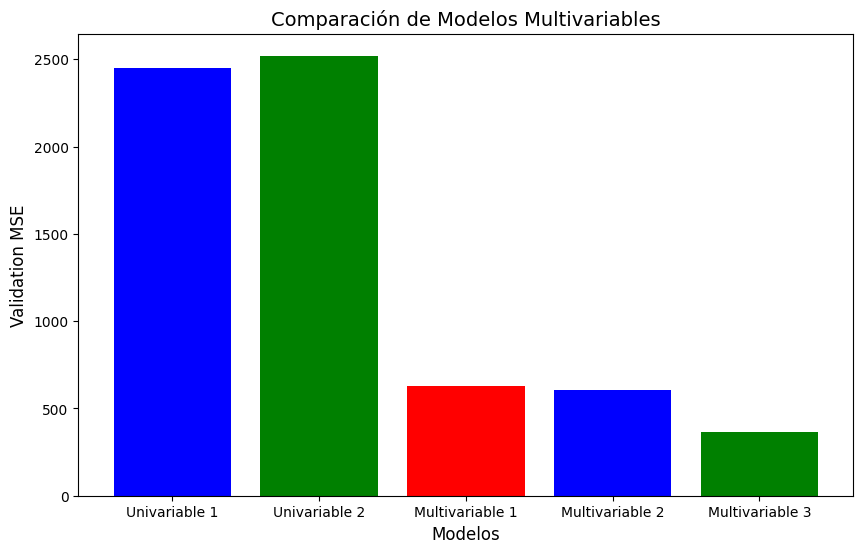

In [24]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Univariable 1','Univariable 2','Multivariable 1', 'Multivariable 2', 'Multivariable 3']

model_results = [2449.91, 2520.60, 625.79, 606.35, 363.61]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_results, color=['blue', 'green', 'red'])

plt.title('Comparación de Modelos Multivariables', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)

plt.show()

In [ ]:
#multivar_model.save('best_model.keras')

## Correcion de comentarios
## Criterio de comparacion del modelo

Iniciando predicciones autoregresivas para los próximos 7 días...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicción 1: 2860.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicción 2: 2860.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicción 3: 2860.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicción 4: 2860.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicción 5: 2860.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicción 6: 2860.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicción 7: 2860.93


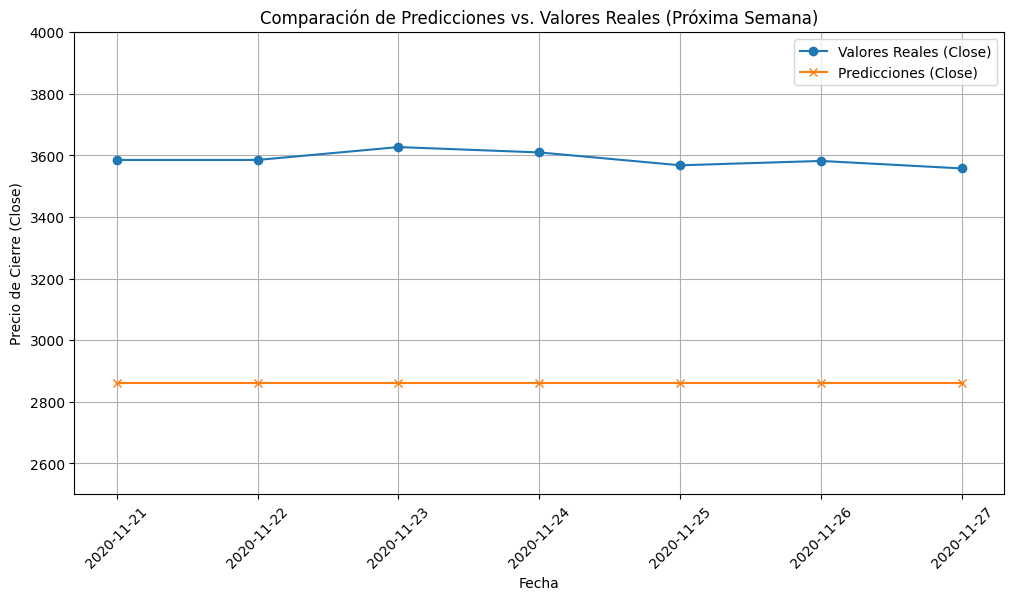

In [23]:
def compare_predictions_autoregressive_debug(model, df):
    # Preparar datos
    df['Date'] = pd.to_datetime(df['Date'])
    df_sorted = df.sort_values(by='Date')
    last_60_days = df_sorted.tail(60)[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].values
    actual_close = df_sorted.tail(7)['Close'].values  # Datos reales de la última semana para comparación
    dates = pd.date_range(start=df_sorted['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)

    # Inicializar entradas para predicciones
    input_data = last_60_days.reshape(1, 60, 6).astype(np.float32)
    predictions = []

    print("Iniciando predicciones autoregresivas para los próximos 7 días...\n")
    for i in range(7):
        # Hacer predicción
        prediction = model.predict(input_data)[0][0]
        predictions.append(prediction)
        print(f"Predicción {i+1}: {prediction:.2f}")

        # Crear nueva fila de entrada reemplazando 'Close' con la predicción
        new_entry = df_sorted.iloc[-7 + i][['High', 'Low', 'Open', 'Volume', 'Adj Close']].values.astype(np.float32)
        new_row = np.append(new_entry, prediction).reshape(1, 1, 6)

        # Actualizar input_data agregando la nueva fila y eliminando el primer día
        input_data = np.append(input_data[:, 1:, :], new_row, axis=1)

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_close, label='Valores Reales (Close)', marker='o')
    plt.plot(dates, predictions, label='Predicciones (Close)', marker='x')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre (Close)')
    plt.title('Comparación de Predicciones vs. Valores Reales (Próxima Semana)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.ylim(2500, 4000)  # Ajusta según tus necesidades
    plt.show()

# Llama a la función con depuración
compare_predictions_autoregressive_debug(multivar_model_3, df)


In [21]:
import datetime as dt

def predict_close(model, df):
    # Pedir la fecha al usuario
    date_input = input("Ingrese la fecha en formato YYYY-MM-DD: ")

    try:
        target_date = dt.datetime.strptime(date_input, "%Y-%m-%d")
    except ValueError:
        print("Formato de fecha inválido. Intente nuevamente.")
        return

    # Filtrar los últimos 60 días
    df['Date'] = pd.to_datetime(df['Date'])
    df_sorted = df[df['Date'] < target_date].sort_values(by='Date').tail(60)

    if len(df_sorted) < 60:
        print("No hay suficientes datos para realizar la predicción.")
        return

    # Preparar los datos de entrada para el modelo
    input_data = df_sorted[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].values.reshape(1, 60, 6)

    # Generar la predicción
    prediction = model.predict(input_data)

    # Mostrar resultado
    print(f"\nPredicción del precio de cierre (Close) para {date_input}: {prediction[0][0]:.2f}")


In [22]:
predict_close(multivar_model_3, df)

Ingrese la fecha en formato YYYY-MM-DD: 2020-11-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predicción del precio de cierre (Close) para 2020-11-11: 2860.95


## CONCLUSION:

Los resultados muestran que los modelos multivariables son notablemente mejores que los univariables en cuanto al error cuadrático medio (MSE). Esto se debe a que el modelo multivariable tiene acceso a más información relevante, como el volumen y el precio de cierre, lo que le permite capturar patrones complejos y mejorar la precisión.

A pesar de esta mejora, la volatilidad del mercado implica que la predicción perfecta es difícil de lograr. Incluso el modelo más avanzado está limitado por la naturaleza impredecible de las acciones.

Finalmente, el modelo funciona mejor con secuencias de 2-3 meses; secuencias más largas (4-6 meses) tienden a introducir ruido, disminuyendo la precisión. Esto sugiere que la información más reciente es clave para realizar predicciones precisas en este contexto.

Áreas de Mejora: Explorar arquitecturas más complejas y ajustar hiperparámetros podría optimizar aún más el rendimiento del modelo multivariable.